##### Copyright 2019, The Analytics Zoo Authors, The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License").

# Convolutional VAE: An example with tf.keras and Analytics Zoo

![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif)

This notebook demonstrates how to generate images of handwritten digits using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and train a Variational Autoencoder with [Analytics Zoo](https://analytics-zoo.github.io/). (VAE, [[1]](https://arxiv.org/abs/1312.6114), [[2]](https://arxiv.org/abs/1401.4082)).



In [1]:
# to generate gifs
!pip install imageio

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Import TensorFlow and Analytics Zoo

In [2]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow == 1.10.0
import tensorflow as tf

import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

from zoo import init_nncontext
from zoo.tfpark import TFDataset, KerasModel


Using /usr/local/spark-2.1.0-bin-hadoop2.6
Prepending /usr/local/spark-2.1.0-bin-hadoop2.6/python/lib/py4j-0.10.4-src.zip to sys.path
Prepending /usr/local/spark-2.1.0-bin-hadoop2.6/python/lib/pyspark.zip to sys.path
Prepending /home/bozhou/.pyenv/versions/3.5.4/lib/python3.5/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

## Use *zoo.tfpark.TFDataset* to create dataset

In [5]:
sc = init_nncontext()
# train_rdd = sc.parallelize(train_images).zip(sc.parallelize(train_images))
# test_rdd = sc.parallelize(test_images).zip(sc.parallelize(test_images))
# train_dataset = TFDataset.from_rdd(train_rdd,
#                                    features=(tf.float32, [28, 28, 1]),
#                                    labels=(tf.float32, [28, 28, 1]),
#                                    batch_size=280)
# test_dataset = TFDataset.from_rdd(test_rdd,
#                                   features=(tf.float32, [28, 28, 1]),
#                                   labels=(tf.float32, [28, 28, 1]),
#                                   batch_per_thread=280)

## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions. 

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [6]:
class CVAE:
  def __init__(self, latent_dim):
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )
    
    self.split_layer = tf.keras.layers.Lambda(
        lambda x: tf.split(x, num_or_size_splits=2, axis=1),
        output_shape=((self.latent_dim,),
                      (self.latent_dim,))
    )

    self.reparam_layer = tf.keras.layers.Lambda(
        lambda x: tf.random_normal(shape=tf.shape(x[0])) * tf.exp(x[1] * .5) + x[0],
        output_shape=(self.latent_dim,)
    )


    self.model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            self.inference_net,
            tf.keras.layers.Lambda(
                lambda x: self.reparam_layer(self.split_layer(x)),
                output_shape=(self.latent_dim,)
            ),
            self.generative_net
        ]
    )

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net.predict(z)
    if apply_sigmoid:
      probs = 1/(1 + np.exp(-logits))

      return probs

    return logits

Get our VAE model

In [ ]:
latent_dim = 50
vae = CVAE(latent_dim)

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [7]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(y_true, y_pred):
    mean, logvar = vae.split_layer(vae.inference_net(y_true))
    z = vae.reparam_layer((mean, logvar))
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,
                                                        labels=y_true)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

optimizer = tf.train.AdamOptimizer(1e-4)

## Compile Keras model and wrap with Analytics Zoo
Now compile the model with loss and optimizer, and wrap keras model with `zoo.tfpark.KerasModel`

In [ ]:
vae.model.compile(optimizer, loss=compute_loss)
vae.model = KerasModel(vae.model)

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [8]:
epochs = 10
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = np.random.randn(num_examples_to_generate,
                                               latent_dim).astype(np.float32)

In [9]:
def generate_and_save_images(vae, epoch, test_input):
    predictions = vae.decode(test_input, apply_sigmoid=True)
    sqrt = int(np.sqrt(test_input.shape[0]))
    plt.figure(figsize=(sqrt, sqrt))
    for i in range(sqrt * sqrt):
        plt.subplot(sqrt, sqrt, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


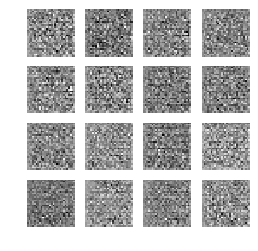

Epoch 1/1
60000/60000 [==============================] - 210s 4ms/step - loss: 191.5658


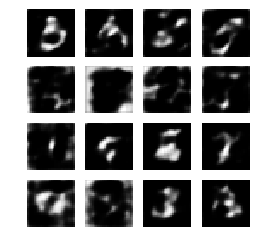

Epoch 1/1
60000/60000 [==============================] - 210s 3ms/step - loss: 119.8814


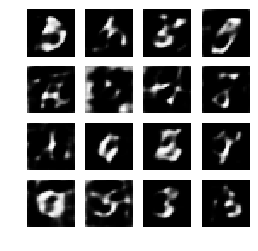

Epoch 1/1
60000/60000 [==============================] - 210s 4ms/step - loss: 106.3460


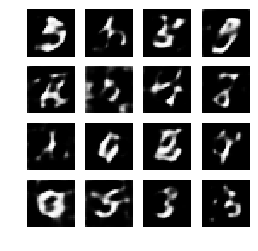

Epoch 1/1
60000/60000 [==============================] - 210s 4ms/step - loss: 99.9627


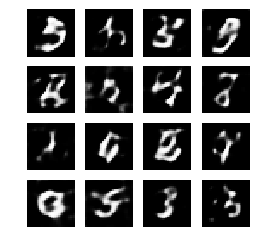

Epoch 1/1
60000/60000 [==============================] - 211s 4ms/step - loss: 96.1410


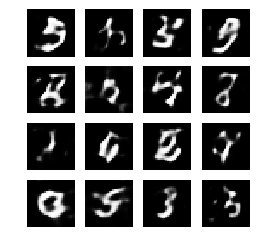

Epoch 1/1
60000/60000 [==============================] - 211s 4ms/step - loss: 93.5228


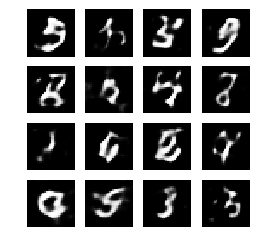

Epoch 1/1
60000/60000 [==============================] - 211s 4ms/step - loss: 91.6488


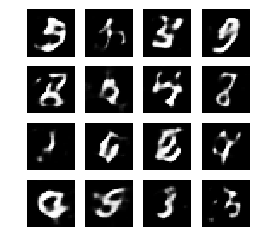

Epoch 1/1
60000/60000 [==============================] - 211s 4ms/step - loss: 90.1772


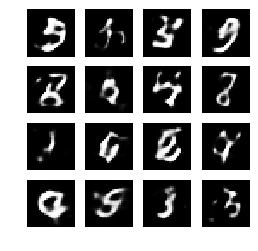

Epoch 1/1
60000/60000 [==============================] - 212s 4ms/step - loss: 89.0089


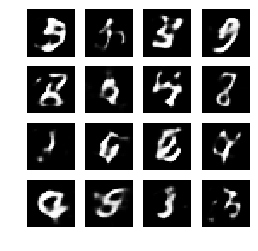

Epoch 1/1
60000/60000 [==============================] - 210s 4ms/step - loss: 88.0020


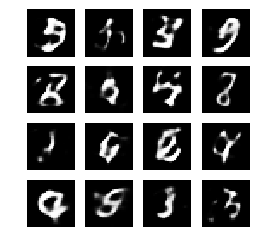

In [10]:
generate_and_save_images(vae, 0, random_vector_for_generation)

# Training model and record the generated image after each epoch
for epoch in range(1, epochs + 1):
    # vae.model.fit(train_dataset,
    #               epochs=1,
    #               distributed=True)
    vae.model.fit(train_images,
                  train_images,
                  batch_size=32,
                  epochs=1)
    generate_and_save_images(vae, epoch, random_vector_for_generation)

### Display an image using the epoch number

In [11]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

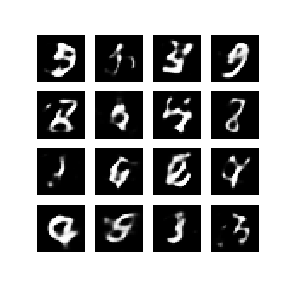

In [12]:
epochs = 10
display_image(epochs)  # Display images

### Generate a GIF of all the saved images.

In [13]:
with imageio.get_writer('cvae.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp cvae.gif cvae.gif.png')

0

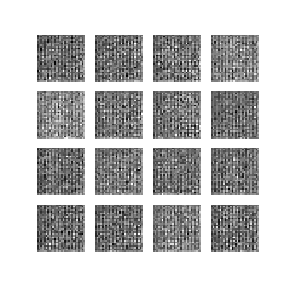

In [6]:
display.Image(filename="cvae.gif.png")